<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/06_transfer_learning_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TF Part 3: Scaling Up

In [12]:
import tensorflow as tf

In [13]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [14]:
# import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

In [15]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [16]:
walk_through_dir(train_dir)

There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are

In [17]:
# Setup data inputs
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train the Big Model

In [18]:
# create Checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [19]:
# create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmention
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name="data_augmentation")

In [20]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture wit trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation="softmax",  name="output_layer")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# get a summary of model we've created
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

history_10_percent = model.fit(train_data_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 112s 433ms/step - loss: 3.6036 - accuracy: 0.2178 - val_loss: 2.5700 - val_accuracy: 0.4121
Epoch 2/5
237/237 [==============================] - 99s 417ms/step - loss: 2.5281 - accuracy: 0.4260 - val_loss: 2.0549 - val_accuracy: 0.4978
Epoch 3/5
237/237 [==============================] - 94s 394ms/step - loss: 2.1576 - accuracy: 0.4896 - val_loss: 1.8446 - val_accuracy: 0.5328
Epoch 4/5
237/237 [==============================] - 92s 383ms/step - loss: 1.9584 - accuracy: 0.5278 - val_loss: 1.7312 - val_accuracy: 0.5489
Epoch 5/5
237/237 [==============================] - 88s 372ms/step - loss: 1.8114 - accuracy: 0.5527 - val_loss: 1.6723 - val_accuracy: 0.5597


In [23]:
model.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.6723 - accuracy: 0.5597


[1.6723135709762573, 0.5596831440925598]

In [24]:
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 66s 81ms/step


In [25]:
pred_classes = pred_probs.argmax(axis=1)

In [26]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.44      0.11      0.17       250
           1       0.50      0.70      0.58       250
           2       0.52      0.55      0.54       250
           3       0.67      0.54      0.60       250
           4       0.51      0.38      0.44       250
           5       0.56      0.30      0.39       250
           6       0.80      0.69      0.74       250
           7       0.86      0.63      0.73       250
           8       0.30      0.52      0.38       250
           9       0.25      0.84      0.38       250
          10       0.63      0.34      0.44       250
          11       0.65      0.53      0.58       250
          12       0.74      0.49      0.59       250
          13       0.48      0.64      0.55       250
          14       0.34      0.71      0.46       250
          15       0.50      0.19      0.27       250
          16       0.73      0.46      0.57       250
          17       0.43    

In [30]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [33]:
class_names = train_data_10_percent.class_names

In [34]:
class_f1_scores = {}

for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.17363344051446944,
 'baby_back_ribs': 0.5843071786310517,
 'baklava': 0.53515625,
 'beef_carpaccio': 0.6004415011037527,
 'beef_tartare': 0.43636363636363634,
 'beet_salad': 0.3896103896103896,
 'beignets': 0.7413793103448275,
 'bibimbap': 0.7251732101616628,
 'bread_pudding': 0.37829912023460405,
 'breakfast_burrito': 0.38173515981735157,
 'bruschetta': 0.4444444444444444,
 'caesar_salad': 0.584070796460177,
 'cannoli': 0.5899280575539568,
 'caprese_salad': 0.5532646048109966,
 'carrot_cake': 0.45974025974025984,
 'ceviche': 0.2732558139534884,
 'cheese_plate': 0.5686274509803921,
 'cheesecake': 0.3947939262472885,
 'chicken_curry': 0.46341463414634143,
 'chicken_quesadilla': 0.5233968804159446,
 'chicken_wings': 0.6640159045725647,
 'chocolate_cake': 0.5354969574036511,
 'chocolate_mousse': 0.35658914728682173,
 'churros': 0.6985645933014353,
 'clam_chowder': 0.7128309572301427,
 'club_sandwich': 0.5797101449275363,
 'crab_cakes': 0.35,
 'creme_brulee': 0.678260869565

In [36]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_names,f1-score
33,edamame,0.932331
32,dumplings,0.856566
69,oysters,0.838843
86,sashimi,0.822612
54,hot_and_sour_soup,0.816406
...,...,...
93,steak,0.242991
39,foie_gras,0.230303
50,grilled_salmon,0.218543
82,ravioli,0.197531


from matplotlib import pyplot as plt
f1_scores['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
f1_scores['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

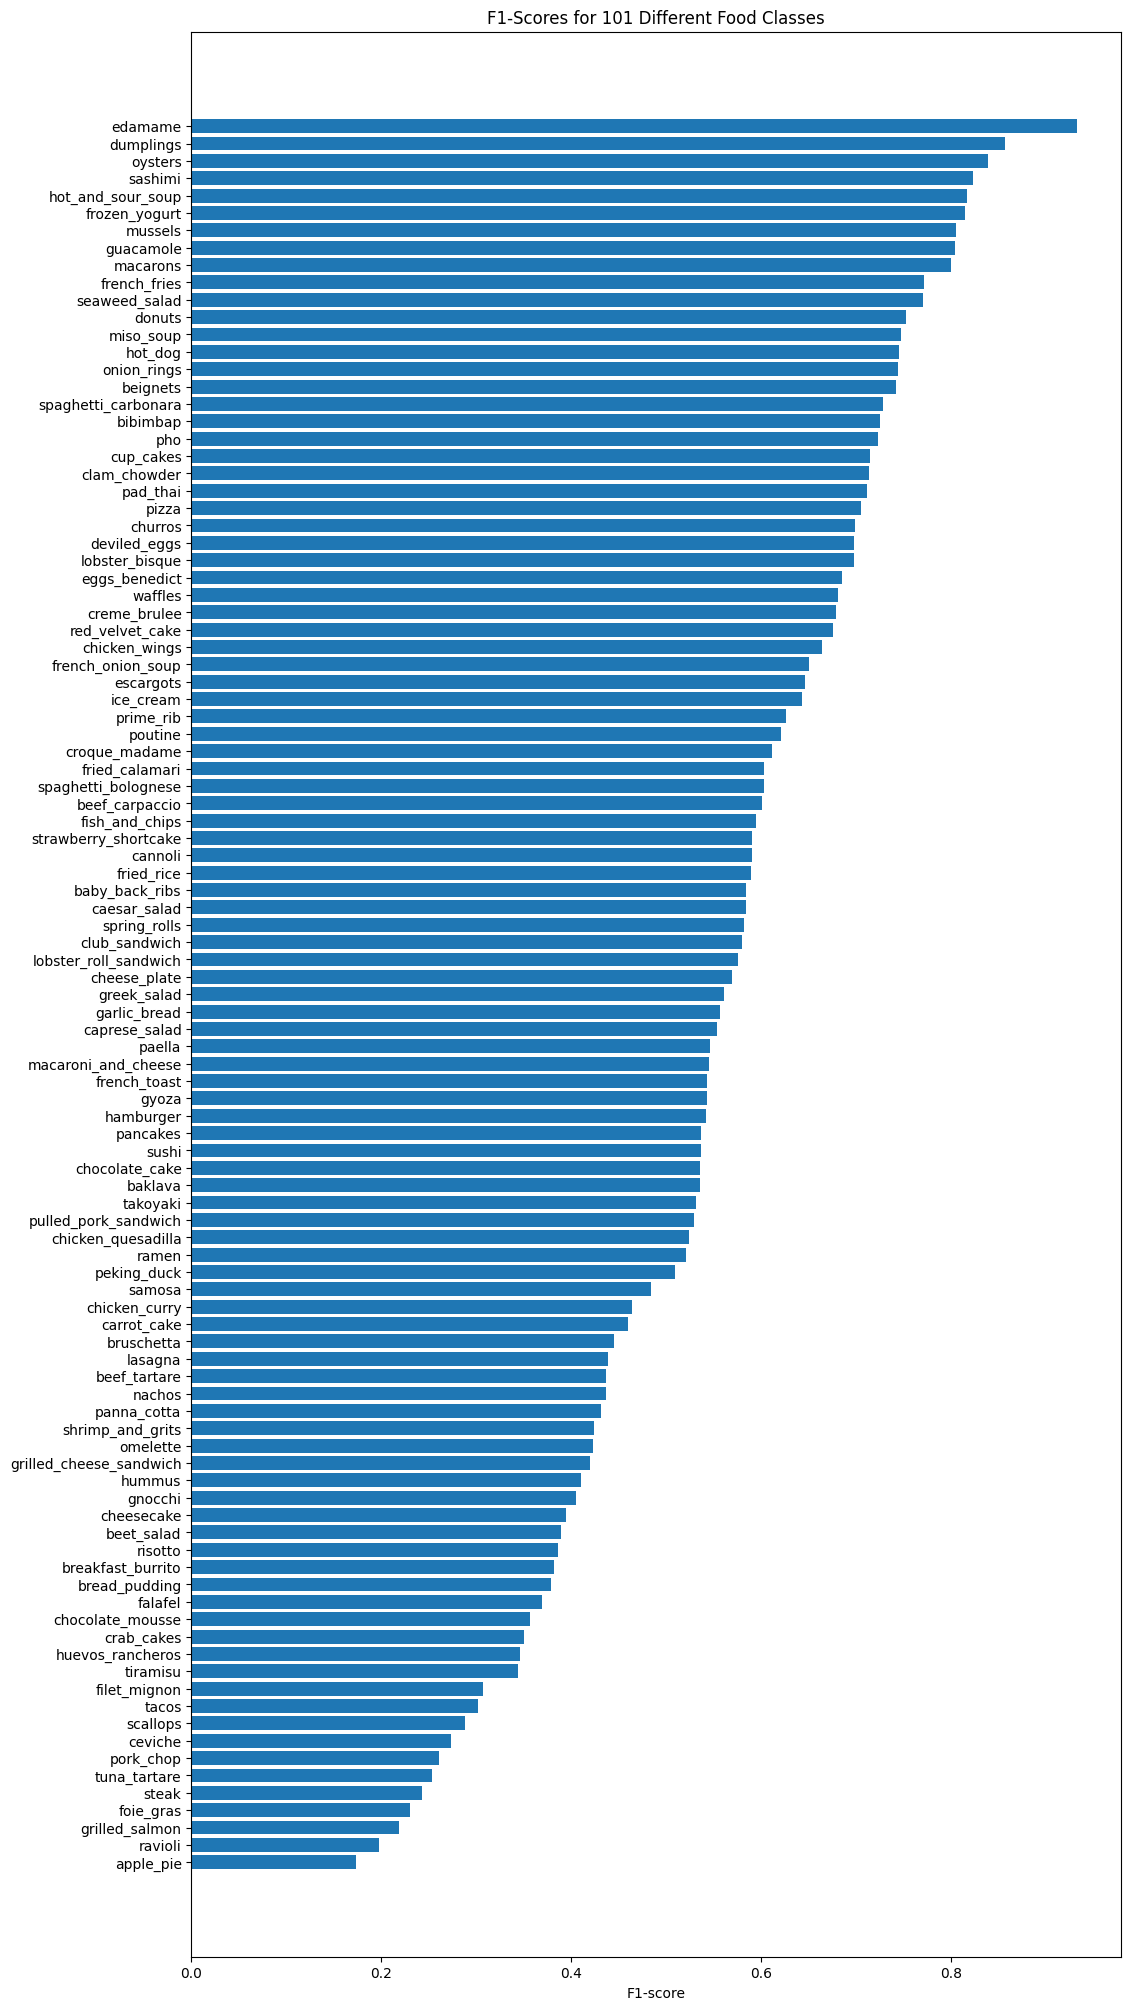

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-Scores for 101 Different Food Classes")
ax.invert_yaxis()

In [48]:
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  9, 41])

In [47]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Visualizing predictions n custom images

In [50]:
# create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img, channels=3)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 27ms/step


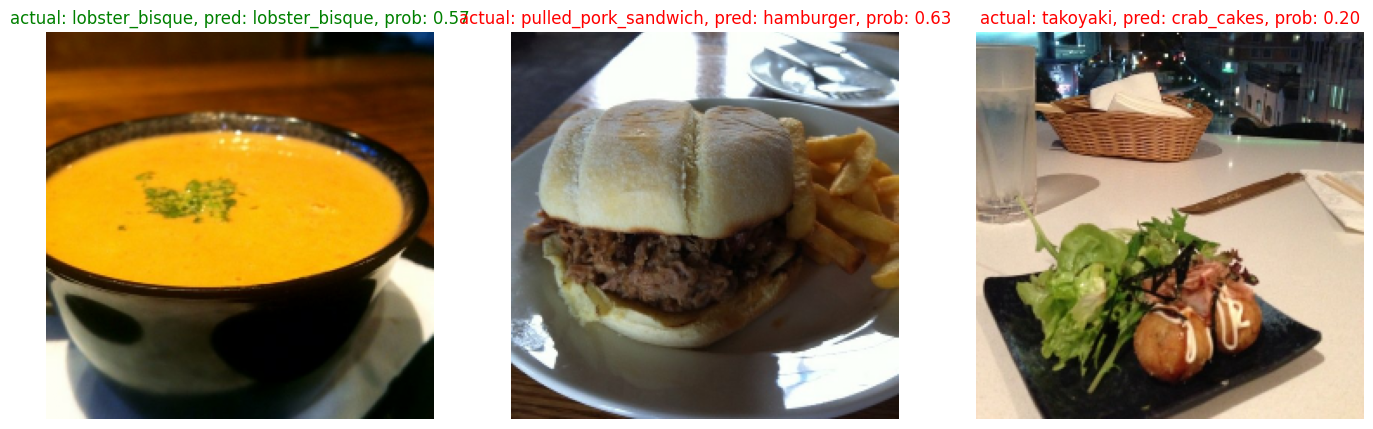

In [82]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

In [70]:
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [72]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.394799,apple_pie,samosa
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.338488,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.162880,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.145047,apple_pie,apple_pie
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.329337,apple_pie,bread_pudding
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.764623,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.936946,waffles,waffles
25247,b'/content/101_food_classes_10_percent/test/wa...,100,56,0.252362,waffles,huevos_rancheros
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.173543,waffles,strawberry_shortcake


In [73]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,85,0.394799,apple_pie,samosa,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.338488,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.162880,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.145047,apple_pie,apple_pie,True
4,b'/content/101_food_classes_10_percent/test/ap...,0,8,0.329337,apple_pie,bread_pudding,False
...,...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.764623,waffles,waffles,True
25246,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.936946,waffles,waffles,True
25247,b'/content/101_food_classes_10_percent/test/wa...,100,56,0.252362,waffles,huevos_rancheros,False
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.173543,waffles,strawberry_shortcake,False


In [75]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.980198,sushi,sashimi,False
14482,b'/content/101_food_classes_10_percent/test/hu...,57,51,0.969673,hummus,guacamole,False
5114,b'/content/101_food_classes_10_percent/test/ch...,20,38,0.958932,chicken_wings,fish_and_chips,False
18935,b'/content/101_food_classes_10_percent/test/ph...,75,33,0.950266,pho,edamame,False
20478,b'/content/101_food_classes_10_percent/test/ra...,81,75,0.947655,ramen,pho,False
2030,b'/content/101_food_classes_10_percent/test/br...,8,41,0.935217,bread_pudding,french_onion_soup,False
9690,b'/content/101_food_classes_10_percent/test/fi...,38,20,0.933681,fish_and_chips,chicken_wings,False
18640,b'/content/101_food_classes_10_percent/test/pe...,74,85,0.933455,peking_duck,samosa,False
7791,b'/content/101_food_classes_10_percent/test/do...,31,84,0.928317,donuts,risotto,False
23992,b'/content/101_food_classes_10_percent/test/su...,95,86,0.923163,sushi,sashimi,False


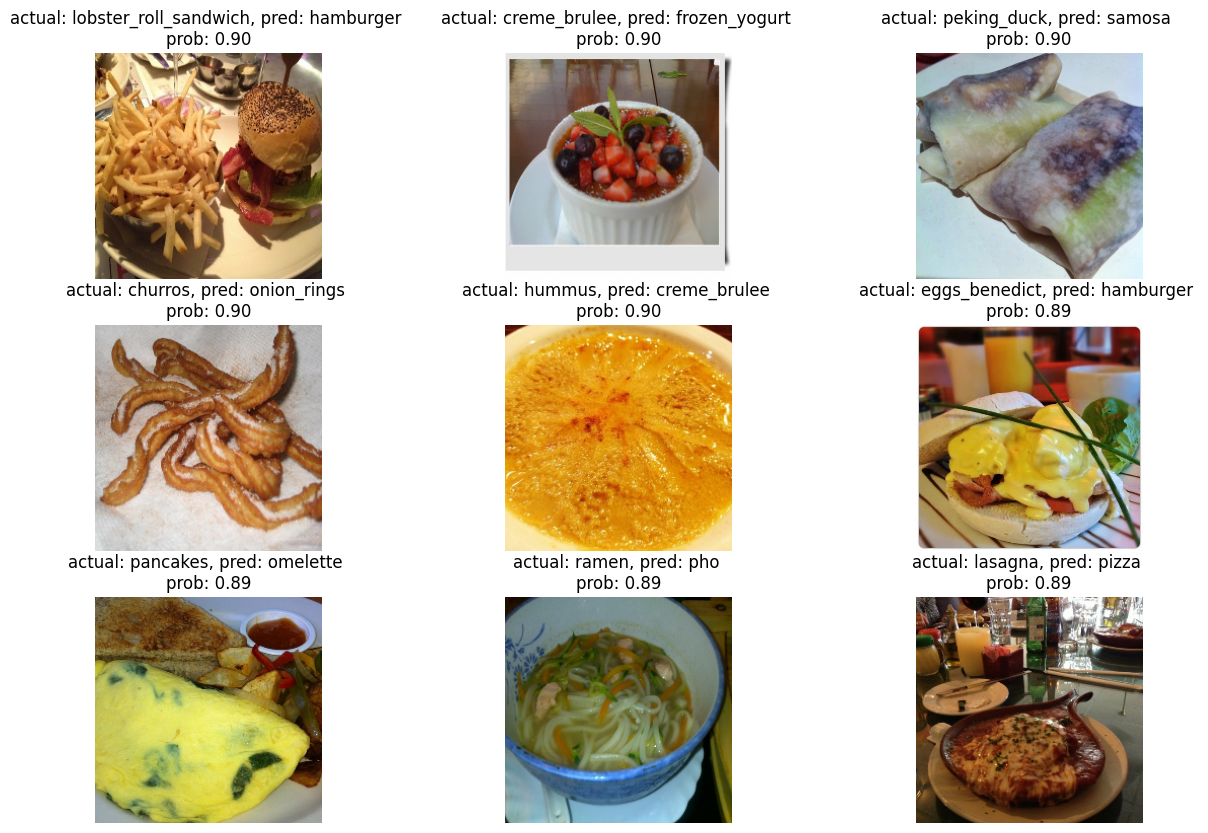

In [81]:
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row[1], scale=False)/255.
  _,_,_,_, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob:.2f}")
  plt.axis(False)